<a href="https://colab.research.google.com/github/djmalice/GenAInotebooks/blob/main/Classification_bird_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Google Colab notebook is based on the Kaggle notebook here: https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data, which is linked from Chapter 1 of the fast.ai Practical Deep Learning course. The original version uses a different image search library which seems to not work consistently.

## Is it a bird?

In [ ]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities

!pip install -U duckduckgo_search
!pip install fastai
!pip install fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 8.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinu

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

![image.png](https://imgs.xkcd.com/comics/tasks_2x.png)

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of birds and non-birds

In [ ]:
from fastbook import *
from fastai.vision.widgets import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(search_images_ddg(term, max_images=max_images))


Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [ ]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get an error, you can skip this cell, which is just to peek at the first image.
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'https://a-z-animals.com/media/2022/06/Lovebirds-on-fence.jpg'

...and then download a URL and take a look at it:

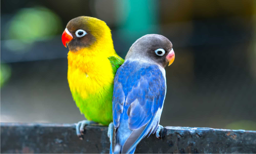

In [ ]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

In [ ]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get an error, you can skip this cell, which is just to peek at the first image.
urls1 = search_images('forest photos', max_images=1)
download_url(urls1[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Searching for 'forest photos'


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1007)>

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [ ]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


In [ ]:
print(path)
searches = 'forest','bird'

for imageType in searches:
    print(imageType)
    content = os.listdir(path/imageType)
    for element in content:
        print(element)

bird_or_not
forest
f747831c-19c3-49f6-ba9c-0deaf7ec74fa.jpg
4436bd98-6985-431a-993a-294cbd7f057d.jpg
92c1e33b-0535-45f2-bb82-97d4a5601a0f.jpg
eee50b1e-fdec-419a-adb6-d54a84212e72.jpg
948bb66b-0137-472b-a07f-db3bd15eab36.jpg
37c24b06-0b02-43d0-8a8e-c7b8d01a1fa8.jpg
c7e1355b-f1fd-4318-9c70-2642a5d25e86.jpg
fb26b3f1-d7c6-4043-b44f-3eedad2b7ce4.jpg
94f521b9-a13d-41a3-a26d-f17f4e365882.jpg
688f99b9-bc27-4650-a38e-d62548c4bc6e.jpg
fd9cd94e-3ed9-499d-ba73-356f34f3f67e.jpg
70c7eb5c-9764-4359-8a8e-2fbdfaeb4335.jpg
a053423b-c502-444e-8757-5904bf419adf.jpg
6efed884-f5e8-4cf9-b50f-82f0d98b4801.jpg
9c0525fe-8683-4708-9ea1-266d9a187206.jpg
ff77fa60-d900-4252-8076-914103069bb9.jpg
750c88ec-420c-49bd-9c7a-537d5b551b19.jpg
72b750c3-7079-4f97-97c0-aff9f47d0d8d.jpg
f97134af-46ee-4ae1-9cfd-f4ce6efd39a7.jpg
ba74e26b-03ad-439a-b232-2b4cc356e85d.jpg
6f687130-3c0e-478e-b009-dc018341f342.jpg
611b65c2-206f-4226-899f-4cda0a2e3c51.jpg
96f43c46-17f1-4d88-88eb-1393df955ebe.jpg!d
65b78ddb-9ad1-4696-86be-9714dfd38e1f

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

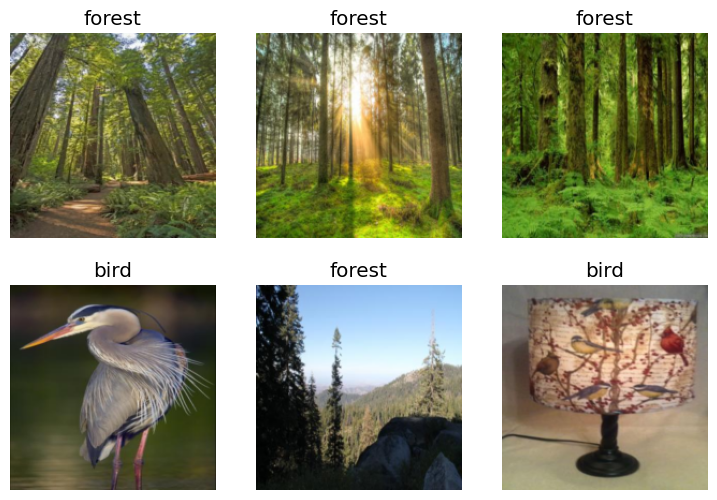

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files,

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 151MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.082824,0.291365,0.125000,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.185546,0.072795,0.031250,00:01
1,0.115678,0.024131,0.000000,00:01
2,0.086780,0.017372,0.000000,00:01


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [ ]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Save this notebook to your own Google Drive and try creating your own image classifier using your own image searches!